<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
urlArchivos = "https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing"

In [27]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
###################################################################################################
BASE_FOLDER = '/content/drive/My Drive/Master IA/Redes Neuronales/'
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/Redes Neuronales/'
###################################################################################################

In [29]:
!ls "/content/gdrive/My Drive/Master IA/Redes Neuronales/"

'07MAIR_Actividad 1.ipynb'   pickle_all_classes.pickle
 caltech101_dataset	     pickle_all_images_df-002.pickle
 caltech101_dataset.zip      preprocesado_caltech101.ipynb


In [0]:
import pickle
import matplotlib.pyplot as plt
import numpy as np


from keras import models
from keras import layers


from sklearn.model_selection import train_test_split

In [31]:
with open(BASE_FOLDER+"pickle_all_images_df-002.pickle", "rb") as input_file:
    x_train_all = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train_all = pickle.load(input_file)

number_of_classes = len(y_train_all)

print("Entradas: ",x_train_all.shape)
print("Salidas: ", number_of_classes)

Entradas:  (9145, 128, 128, 3)
Salidas:  9145


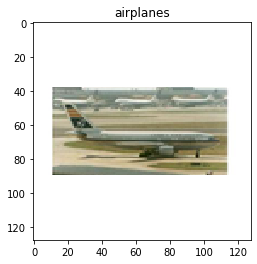

In [32]:
# show image
imagenVer = 250

imgplot = plt.imshow(x_train_all[imagenVer])
plt.title(y_train_all[imagenVer])
plt.show()

In [0]:
# Transformando las labels de texto a valores numéricos
y = np.unique(y_train_all)
mapping = { key : value for key,value in zip(y,range(len(y)))}
processed_y = np.array([mapping[i] for i in y_train_all])

In [34]:
print(processed_y[imagenVer], y_train_all[imagenVer])

6 airplanes


In [50]:
# dividir los datos entre training, test y predic

X_train, X_test, y_train, y_test = train_test_split(
    x_train_all, processed_y, 
    test_size=0.33, 
    random_state=42)
 
print("X_train", X_train.shape)
print("y_train", len(y_train))
print()

X_test_eval, X_test_predic, y_test_eval, y_test_predic = train_test_split(
    X_test, y_test, 
    test_size=0.33, 
    random_state=51)
 
print("X_test_eval", X_test_eval.shape)
print("y_test_eval", len(y_test_eval))
print()
print("X_test_predic", X_test_predic.shape)
print("y_test_predic", len(y_test_predic))

X_train (6127, 128, 128, 3)
y_train 6127

X_test_eval (2022, 128, 128, 3)
y_test_eval 2022

X_test_predic (996, 128, 128, 3)
y_test_predic 996


In [36]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet

from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, # incluir la parte densa (fully connected)
                 input_shape=(128,128,3))

from keras.applications.inception_v3 import InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=True)

congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 4 layers
  cantidadCapasFinalesDescongelar = 4
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)



#conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [45]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)

# conectarlo a nueva parte densa
pre_trained_model.add(layers.Dense(number_of_classes, activation='relu'))
pre_trained_model.add(layers.Dense(1, activation='relu'))

pre_trained_model.summary()

# compilar el modelo
pre_trained_model.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

#entrenar el modelo
history = pre_trained_model.fit(X_train, y_train, epochs=25)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1000)              23851784  
_________________________________________________________________
dense_12 (Dense)             (None, 9145)              9154145   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9146      
Total params: 33,015,075
Trainable params: 11,212,291
Non-trainable params: 21,802,784
_________________________________________________________________



ValueError: ignored

In [0]:
loss,accuracy = pre_trained_model.evaluate(X_test_eval,y_test_eval)

print('loss {} accuracy {}'.format(loss,accuracy))

In [0]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
print("conjunto datos predecir: ", len(X_test_predic))
cantidadPorcentajesMostrar = 5 #muestra los de mayor porcentaje

from keras.applications.inception_v3 import decode_predictions
prediccion = pre_trained_model.predict(X_test_predic[0])
decode_predictions(prediccion, top=cantidadPorcentajesMostrar)[0]